### Лабораторная работа №4: Деревья решений 
##### Выполнил студент группы: 6131-010402D Павлов Владислав

### 1. Загрузка датасета

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

In [2]:
df = pd.read_csv("big_dataset.csv")

### 2.1 Описание датасета 

#### Большой набор данных о мошенничестве с онлайн-платежами
#### Цель - определить тип транзакции мошенническая или обычная

| Признак | Описание | Единицы измерения |
|:-------:|:--------:|:-----------------:|
| step | Шаг | numerical |
| type | Тип онлайн-транзакции | categorical |
| amount | Сумма транзакции | numerical |
| nameOrig | Клиент, запускающий транзакцию | categorical |
| oldbalanceOrg | Баланс до транзакции | numerical |
| newbalanceOrig | Баланс после транзакции | numerical | 
| nameDest | Получатель транзакции | categorical |
| oldbalanceDest | Баланс получателя до транзакции | numerical |
| newbalanceDest | Баланс получателя после транзакции | numerical |
| isFraud | Мошенническая транзакция  | binary |
| isFlaggedFraud | Флаг транзакции | binary |

##### Целевой класс содержит два значения - 0 или 1, где 0 - обычная транзакция, 1 - мошенническая транзакция



In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Так как датасет очень большой, возьму от исходного 1/80 часть 

In [5]:
df_length = len(df)
part = df_length // 80

part_df = df.sample(n = part)
print(part_df)

         step      type     amount     nameOrig  oldbalanceOrg  \
5816910   401   PAYMENT   31918.48   C201001395       16589.00   
3986941   298   CASH_IN  181578.03    C74838481     1052789.75   
2616490   208   CASH_IN  164020.53   C503408982     9281052.92   
2040577   181  CASH_OUT  282172.95  C1160940772           0.00   
5702034   398   CASH_IN   79072.41  C1806364006     3525537.58   
...       ...       ...        ...          ...            ...   
1426021   139  CASH_OUT   23600.68  C1271117967        1437.00   
4962664   351   CASH_IN  245273.99  C2138175875     1507631.48   
4358398   309   PAYMENT   68523.05  C1104317803           0.00   
2327438   188   PAYMENT     715.27   C855491369       10275.00   
3737576   278  CASH_OUT  252864.91  C1491117033           0.00   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
5816910            0.00  M1127441114            0.00            0.00        0   
3986941      1234367.78  C1798569326       31

### 2.2 Предобработка данных

In [6]:
# Проверка на наличие null
part_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
columns_drop = ["step","nameOrig","nameDest", "isFlaggedFraud"]
df_dropped = part_df.drop(columns = columns_drop, axis= 1)


### 2.3 Кодировка категориальных признаков

In [8]:
unique_values = df_dropped["type"].unique()
print(unique_values)

['PAYMENT' 'CASH_IN' 'CASH_OUT' 'TRANSFER' 'DEBIT']


In [9]:
df_dropped["type"] = df_dropped["type"].replace({'PAYMENT': 0, 'TRANSFER': 1, 'CASH_OUT': 2, 'DEBIT': 3, 'CASH_IN': 4}) 

C:\Temp\ipykernel_14572\1923001620.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dropped["type"] = df_dropped["type"].replace({'PAYMENT': 0, 'TRANSFER': 1, 'CASH_OUT': 2, 'DEBIT': 3, 'CASH_IN': 4})


### 2.4 Нормализация данных

In [10]:
x = df_dropped.drop("isFraud", axis = 1)
y = df_dropped["isFraud"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled_df = pd.DataFrame(x_scaled, columns = x.columns)

In [11]:
x_scaled_df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,-1.133505,-0.217064,-0.282505,-0.291951,-0.345459,-0.347730
1,1.549549,-0.004237,0.071763,0.125056,-0.244720,-0.308631
2,1.549549,-0.029205,2.884933,2.898886,0.278177,0.168075
3,0.208022,0.138817,-0.288176,-0.291951,0.859274,0.819507
4,1.549549,-0.150008,0.917173,0.925797,-0.239301,-0.274513


### 2.5 Разбивка выборки на обучающую и тестовую

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 42)

### 3. Дерево решений
#### 3.1 С использованием GridSearchCV осуществить подбор гиперпараметра DesicionTreeClassifier

In [13]:
grid = {
    'max_depth': range(1, x.shape[1]),
    'max_features': range(2, 20),
    'min_samples_leaf': range(5, 20)
}

model = DecisionTreeClassifier()

search = GridSearchCV(model, grid, cv = 5, n_jobs= -1, verbose = 2)
search.fit(x_train, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6), 'max_features': range(2, 20),
                         'min_samples_leaf': range(5, 20)},
             verbose=2)

### 3.2 Вывести значение гиперпараметра и метрик для наилучшей модели DecisionTreeClassifier

In [14]:
search.best_params_

{'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 5}

In [15]:
best_model = search.best_estimator_
best_model_pred = best_model.predict(x_train)

In [16]:
tree_model_acc = accuracy_score(y_train, best_model_pred)
tree_model_prec = precision_score(y_train, best_model_pred)
tree_model_rec = recall_score(y_train, best_model_pred)
tree_model_f1 = f1_score(y_train, best_model_pred)

print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")

Accuracy: 0.9993892800689754; Precision: 0.8823529411764706; Recall: 0.6164383561643836; F1_score: 0.7258064516129032


### 3.3 Для получения наилучшего дерева вывести feature_importances, отсортировать по убыванию


In [17]:

feature_importances = best_model.feature_importances_

feature_importance_dict = {feature: importance for feature, importance in zip(x_train.columns, feature_importances)}

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Отсортированные значения feature_importances по убыванию:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


Отсортированные значения feature_importances по убыванию:
oldbalanceOrg: 0.418261916445817
newbalanceDest: 0.35608098639521996
type: 0.1620945864229234
newbalanceOrig: 0.03304053802270078
amount: 0.030521972713338848
oldbalanceDest: 0.0


### 3.4 Осуществить фильтрацию признаков 

In [18]:
threshold = np.mean([value for _, value in sorted_feature_importance])
selected_features = [feature for feature, value in sorted_feature_importance if value > threshold]
selected_features

['oldbalanceOrg', 'newbalanceDest']

### 3.5 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками 

In [19]:
x_train_filtered = x_train[selected_features]
# x_train_filtered.head()

search_filtered = GridSearchCV(model, grid, cv = 5, n_jobs= 20, verbose= 2)
search_filtered.fit(x_train_filtered, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=20,
             param_grid={'max_depth': range(1, 6), 'max_features': range(2, 20),
                         'min_samples_leaf': range(5, 20)},
             verbose=2)

### 3.6 Вывести полученные гиперпараметры лучшей модели

In [20]:
search_filtered.best_params_

{'max_depth': 1, 'max_features': 2, 'min_samples_leaf': 5}

### 3.7 Сравнить метрики до и после фильтрации признаков лучших моделей

In [21]:
best_model_filtered = search_filtered.best_estimator_
best_model__filtered_pred = best_model_filtered.predict(x_train_filtered)

In [22]:
tree_model__filtered_acc = accuracy_score(y_train, best_model__filtered_pred)
tree_model__filtered_prec = precision_score(y_train, best_model__filtered_pred)
tree_model__filtered_rec = recall_score(y_train, best_model__filtered_pred)
tree_model__filtered_f1 = f1_score(y_train, best_model__filtered_pred)

print("Before:")
print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")

print("After:")
print(f"Accuracy: {tree_model__filtered_acc}; Precision: {tree_model__filtered_prec}; Recall: {tree_model__filtered_rec}; F1_score: {tree_model__filtered_f1}")

Before:
Accuracy: 0.9993892800689754; Precision: 0.8823529411764706; Recall: 0.6164383561643836; F1_score: 0.7258064516129032
After:
Accuracy: 0.9986887483833884; Precision: 0.0; Recall: 0.0; F1_score: 0.0


c:\Users\Vasser232\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### После фильтрации признаков, значение метрик ухудшилось, но не значительно 

### 4. Случайный лес
#### 4.1 Построить случайный лес (Random Forest Classifier), с использованием GridSearchCV осуществить подбор гиперпараметра

In [23]:
forest_model = RandomForestClassifier()

forest_grid = {
    'max_depth': range(1, x.shape[1]),
    'n_estimators': range(10, 160, 5)
}

forest_search = GridSearchCV(forest_model, forest_grid, cv = 5, n_jobs= -1, verbose= 2)
forest_search.fit(x_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(10, 160, 5)},
             verbose=2)

### 4.2 Вывести полученные гиперпараметры лучшей модели случайного леса

In [24]:
forest_search.best_params_

{'max_depth': 5, 'n_estimators': 10}

### 4.3 Осуществить фильтрацию признаков

In [25]:
forest_best_model = forest_search.best_estimator_

In [26]:
forest_feature_importances = forest_best_model.feature_importances_

forest_feature_importance_dict = {feature: importance for feature, importance in zip(x_train.columns, forest_feature_importances)}

forest_sorted_feature_importance = sorted(forest_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Отсортированные значения feature_importances по убыванию:")
for feature, importance in forest_sorted_feature_importance:
    print(f"{feature}: {importance}")


Отсортированные значения feature_importances по убыванию:
oldbalanceOrg: 0.35598457302157377
newbalanceDest: 0.2715090337371031
amount: 0.15671653320597373
type: 0.11574650853745157
oldbalanceDest: 0.05990706301197135
newbalanceOrig: 0.04013628848592638


In [27]:
forest_threshold = np.mean([value for _, value in forest_sorted_feature_importance])
forest_selected_features = [feature for feature, value in forest_sorted_feature_importance if value > forest_threshold]
forest_selected_features

['oldbalanceOrg', 'newbalanceDest']

### 4.4 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками.

In [28]:
x_train_forest_filtered = x_train[forest_selected_features]
x_train_forest_filtered.head()

,oldbalanceOrg,newbalanceDest
4512713,31972.0,0.00
5226409,29392.0,3338815.44
3120952,0.0,909300.47
5306233,67223.0,8342655.90
5661317,2371.0,373533.92


In [29]:
forest_search_filtered = GridSearchCV(forest_model, forest_grid, cv = 5, n_jobs= -1, verbose= 2)
forest_search_filtered.fit(x_train_forest_filtered, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(10, 160, 5)},
             verbose=2)

### 4.5 Вывести полученные гиперпараметры лучшей модели случайного леса.

In [30]:
forest_search_filtered.best_params_

{'max_depth': 1, 'n_estimators': 10}

### 4.6 Сравнить метрики до и после фильтрации признаков лучших моделей.

In [31]:
forest_best_model_filtered = forest_search_filtered.best_estimator_

In [32]:
forest_model_predict = forest_best_model.predict(x_train)
forest_model_filtered_prediict = forest_best_model_filtered.predict(x_train_forest_filtered)

forest_model_acc = accuracy_score(y_train, forest_model_predict)
forest_model_prec = precision_score(y_train, forest_model_predict)
forest_model_rec = recall_score(y_train, forest_model_predict)
forest_model_f1 = f1_score(y_train, forest_model_predict)

forest_model_filtered_acc = accuracy_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_prec = precision_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_rec = recall_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_f1 = f1_score(y_train, forest_model_filtered_prediict)


print("Before:")
print(f"Accuracy: {forest_model_acc}; Precision: {forest_model_prec}; Recall: {forest_model_rec}; F1_score: {forest_model_f1}")

print("After:")
print(f"Accuracy: {forest_model_filtered_acc}; Precision: {forest_model_filtered_prec}; Recall: {forest_model_filtered_rec}; F1_score: {forest_model_filtered_f1}")

Before:
Accuracy: 0.9990479954016381; Precision: 1.0; Recall: 0.273972602739726; F1_score: 0.43010752688172044
After:
Accuracy: 0.9986887483833884; Precision: 0.0; Recall: 0.0; F1_score: 0.0


c:\Users\Vasser232\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Можно сказать, что метрики незначительно ухудшились

### 5. Метод ближайших соседей
#### 5.1 С использованием GridSearchCV осуществить подбор гиперпараметра KNeighborsClassifier (n_neighbors).

In [33]:
knn_model = KNeighborsClassifier()

In [34]:
knn_grid = {'n_neighbors': range(2, 50)}

knn_search = GridSearchCV(knn_model, knn_grid, cv = 5, n_jobs=-1, verbose=2)
knn_search.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 50)}, verbose=2)

### 5.2 Вывести значения гиперпараметра и метрик для наилучшей модели.

In [35]:
knn_search.best_params_

{'n_neighbors': 4}

### 5.3 Осуществить фильтрацию признаков.

In [36]:
knn_filtered = forest_selected_features
x_train_knn_filtered = x_train[knn_filtered]
x_train_knn_filtered.head()

,oldbalanceOrg,newbalanceDest
4512713,31972.0,0.00
5226409,29392.0,3338815.44
3120952,0.0,909300.47
5306233,67223.0,8342655.90
5661317,2371.0,373533.92


### 5.4 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками.

In [37]:
knn_search_filtered = GridSearchCV(knn_model, knn_grid, cv = 5, n_jobs= -1, verbose= 2)
knn_search_filtered.fit(x_train_knn_filtered, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 50)}, verbose=2)

### 5.5 Вывести полученные гиперпараметры лучшей модели случайного леса.

In [38]:
knn_search_filtered.best_params_

{'n_neighbors': 2}

### 5.6 Сравнить метрики до и после фильтрации признаков.

In [39]:
knn_best_model = knn_search.best_estimator_
knn_best_model_filtered = knn_search_filtered.best_estimator_

In [40]:
knn_model_predict = knn_best_model.predict(x_train)
knn_model_filtered_prediict = knn_best_model_filtered.predict(x_train_knn_filtered)

knn_model_acc = accuracy_score(y_train, knn_model_predict)
knn_model_prec = precision_score(y_train, knn_model_predict)
knn_model_rec = recall_score(y_train, knn_model_predict)
knn_model_f1 = f1_score(y_train, knn_model_predict)

knn_model_filtered_acc = accuracy_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_prec = precision_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_rec = recall_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_f1 = f1_score(y_train, knn_model_filtered_prediict)


print("Before:")
print(f"Accuracy: {knn_model_acc}; Precision: {knn_model_prec}; Recall: {knn_model_rec}; F1_score: {knn_model_f1}")

print("After:")
print(f"Accuracy: {knn_model_filtered_acc}; Precision: {knn_model_filtered_prec}; Recall: {knn_model_filtered_rec}; F1_score: {knn_model_filtered_f1}")

Before:
Accuracy: 0.9992276189107631; Precision: 0.8947368421052632; Recall: 0.4657534246575342; F1_score: 0.6126126126126126
After:
Accuracy: 0.998706710734301; Precision: 1.0; Recall: 0.0136986301369863; F1_score: 0.02702702702702703


### 6. Если наблюдается улучшение метрик после фильтрации признаков хотя бы для одной из моделей, то для набора отфильтрованных признаков заново построить наилучшие модели KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, сравнить модели в пункте 7 на одинаковом полученном наборе отфильтрованных признаков. Иначе – пропустить этот пункт.

#### Улучшений замечено не было

### 7. Оценка качества построенных моделей
#### 7.1 Визуализировать любое полученное дерево решений.

[Text(0.7119565217391305, 0.9166666666666666, 'amount <= 3298874.375\ngini = 0.003\nsamples = 55672\nvalue = [55599, 73]\nclass = Secondary'),
 Text(0.5108695652173914, 0.75, 'oldbalanceOrg <= 55913.195\ngini = 0.002\nsamples = 55493\nvalue = [55435.0, 58.0]\nclass = Secondary'),
 Text(0.2391304347826087, 0.5833333333333334, 'amount <= 332.365\ngini = 0.001\nsamples = 37728\nvalue = [37716.0, 12.0]\nclass = Secondary'),
 Text(0.08695652173913043, 0.4166666666666667, 'type <= 0.5\ngini = 0.02\nsamples = 297\nvalue = [294.0, 3.0]\nclass = Secondary'),
 Text(0.043478260869565216, 0.25, 'gini = 0.0\nsamples = 258\nvalue = [258, 0]\nclass = Secondary'),
 Text(0.13043478260869565, 0.25, 'newbalanceOrig <= 21.985\ngini = 0.142\nsamples = 39\nvalue = [36, 3]\nclass = Secondary'),
 Text(0.08695652173913043, 0.08333333333333333, 'gini = 0.375\nsamples = 12\nvalue = [9, 3]\nclass = Secondary'),
 Text(0.17391304347826086, 0.08333333333333333, 'gini = 0.0\nsamples = 27\nvalue = [27, 0]\nclass = Sec

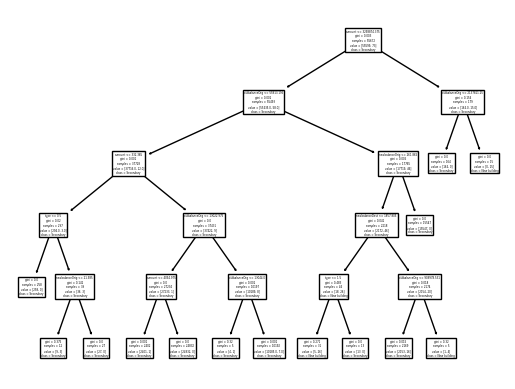

In [43]:
plot_tree(decision_tree=best_model, feature_names=x_train.columns, class_names=['Secondary','New building'])

### 7.2 Сравнить лучшие модели KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier на тестовой выборке. Привести значения метрик.

In [44]:
best_model_pred = best_model.predict(x_test)
forest_model_predict = forest_best_model.predict(x_test)
knn_model_predict = knn_best_model.predict(x_test)


tree_model_acc = accuracy_score(y_test, best_model_pred)
tree_model_prec = precision_score(y_test, best_model_pred)
tree_model_rec = recall_score(y_test, best_model_pred)
tree_model_f1 = f1_score(y_test, best_model_pred)

forest_model_acc = accuracy_score(y_test, forest_model_predict)
forest_model_prec = precision_score(y_test, forest_model_predict)
forest_model_rec = recall_score(y_test, forest_model_predict)
forest_model_f1 = f1_score(y_test, forest_model_predict)

knn_model_acc = accuracy_score(y_test, knn_model_predict)
knn_model_prec = precision_score(y_test, knn_model_predict)
knn_model_rec = recall_score(y_test, knn_model_predict)
knn_model_f1 = f1_score(y_test, knn_model_predict)


print('-----------DECISION TREE-----------')
print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")
print('-----------RANDOM FOREST-----------')
print(f"Accuracy: {forest_model_acc}; Precision: {forest_model_prec}; Recall: {forest_model_rec}; F1_score: {forest_model_f1}")
print('-----------KNN-----------')
print(f"Accuracy: {knn_model_acc}; Precision: {knn_model_prec}; Recall: {knn_model_rec}; F1_score: {knn_model_f1}")

-----------DECISION TREE-----------
Accuracy: 0.9989522212908634; Precision: 0.8928571428571429; Recall: 0.5319148936170213; F1_score: 0.6666666666666666
-----------RANDOM FOREST-----------
Accuracy: 0.9984911986588433; Precision: 1.0; Recall: 0.23404255319148937; F1_score: 0.3793103448275862
-----------KNN-----------
Accuracy: 0.9987007544006706; Precision: 0.9; Recall: 0.3829787234042553; F1_score: 0.5373134328358209
